# Text Scraping and Classification

## Akash Srivastava
## 17201082

###### Importing the required packages

In [1]:
import urllib.request
import bs4
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os

## Task 1: Web Scrapping

##### Function to take the url for each category and return the url containing review for each business

In [2]:
def getData(pageUrl):
    rspn = urllib.request.urlopen(pageUrl)
    category = rspn.read().decode()
    homePage = bs4.BeautifulSoup(category,"html.parser")

    urlPrefix = "http://mlg.ucd.ie/modules/yalp/"
    anchors = []
    anchText = []
    for anchor in homePage.find_all("a", href=True):
        anch = anchor['href'] 
    
        if anch !='': # filtering blank anchor tags
            anchors.append(urlPrefix+anch) #urls of each Business
            anchText.append(anchor.text.replace(':','-')) # names of each business
    return anchText,anchors

##### Function to create a csv file for each category of reviews

In [3]:
# function to crete a file for each category
def createFile(url,path):
    rspn = urllib.request.urlopen(url)
    cat = rspn.read().decode()
    page = bs4.BeautifulSoup(cat,"html.parser")
    #print(page)
    
    ##################
    # retirieving stars for each review
    for ab in page.find_all('img',alt=True):
        star=ab['alt']
        star=star[:1]
        if int(star) >3:
            stars.append("positive")
        else:
            stars.append("negative")
    # retrieving the review text
    for abc in page.find_all('p',{'class':"text"}):
        review=abc.contents
        review=str(review)[2:]
        review=review[:-2]
        reviews.append(review)
        #print(abc.contents)

##### Creating csv files for each review category

In [4]:
dirname = os.getcwd()
pageUrl_automotive = "http://mlg.ucd.ie/modules/yalp/automotive_list.html" # url for category automotive
auto_path=os.path.join(dirname,"review_automotive.csv") # path to save automotive review as csv
pageUrl_bar = "http://mlg.ucd.ie/modules/yalp/bars_list.html" # url for category bars
bar_path=os.path.join(dirname,"review_bars.csv") # path to save bars reviews as csv

stars=[]
reviews=[]
anchText,anchors=getData(pageUrl_automotive)
i=0
path = dirname
for paths in anchText:  # for each business in automotive, geting reviews
    createFile(anchors[i],path+paths)
    i=i+1
data=pd.DataFrame({'review':reviews,'star':stars}) #creating the dataframe for automotive reviews
data.to_csv(auto_path,index=False) # storing the dataframe as csv 



stars=[]
reviews=[]
anchText,anchors=getData(pageUrl_bar)
i=0
for paths in anchText: # for each business in bars getiing reviews
    createFile(anchors[i],path+paths)
    i=i+1

data=pd.DataFrame({'review':reviews,'star':stars}) # creating the dataframe for bars review
data.to_csv(bar_path,index=False) # storing the datafra,e as csv


##### Joining the automotive and bars revies into one dataframe.

The two category of review are joined because if they are not joined, the model constructed on each would accept different shape of input and in task three this will be a pproblem.

In [5]:
data_automotive = pd.read_csv(os.path.join(dirname,"review_automotive.csv"),encoding= "ISO-8859-1")
data_automotive.shape

(1455, 2)

In [6]:
data_bars = pd.read_csv(os.path.join(dirname,"review_bars.csv"),encoding= "ISO-8859-1")
data_bars.shape

(1460, 2)

In [7]:
data_all=pd.concat([data_automotive,data_bars]) # joining the two categories dataframe into one
data_all.shape

(2915, 2)

## Task 2 : Review Classification

##### Checking for null values in the dataframe

In [8]:
data_all.isnull().sum()

review    0
star      0
dtype: int64

No null values are found

### Preprocessing of Data

##### Tokenization

###### Function to tokenize the data

In [9]:
def tokenizer(data):
    tokenize = CountVectorizer().build_tokenizer() # create tokenizer
    reviewTokens = []
    for review in data: # for each review in the dataframe
        lowerReviews = review.lower() #converting review to lowercase "Normalization"
        reviewTokens.append(tokenize(lowerReviews)) 
    return reviewTokens

##### Removing Stopwords

###### Function to remove the stop words from the review

In [10]:
def stopWordRemoval(data):
    stopwords = text.ENGLISH_STOP_WORDS #defining 'english' language stopwords
    reviewList = []
    for tokenisedArray in data:
        filteredWords = []
        for word in tokenisedArray:
            if word not in stopwords:
                filteredWords.append(word)# adding words for each review after stopword removal to alist
        reviewList.append(filteredWords) # adding the review after stop word removal
    return reviewList

#####  Stemming

###### Function to get the list of  stemmed words 

In [11]:
def stemming(data):
    stemmer = PorterStemmer() # Stemmer creation
    stemList = []
    for stemArray in data:
        stemmedWords = []
        for word in stemArray:
            stemmedWords.append(stemmer.stem(word)) # adding words for each review after stemming to a list
        stemList.append(stemmedWords) # adding the stemmed review to a list
    return stemList

In [12]:
review=data_all.review.tolist() # converting the dataframe to a list

tokenised_data=tokenizer(review) # tokenizing 

data_stop=stopWordRemoval(tokenised_data) # removing stop words 

stemmed_data=stemming(data_stop) # stemming


### Document term Matrix

##### Function to create Tf-idf 

In [13]:
def tfidf(data,dataCategory):
    reviewCombined = []
    for lists in data:
        file = ' '.join(lists) # combining the each review list back to form a review
        reviewCombined.append(file)

    vectorizer = TfidfVectorizer() # creating tfidf vectorizer
    X = vectorizer.fit_transform(reviewCombined).toarray()
    Y = dataCategory.star.values
    return X,Y,vectorizer


X,Y,vect=tfidf(stemmed_data,data_all) # calling method to get tfidf

C:\Users\Akash Srivastava\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [14]:
# Displaying the tfidf 
Tfidf_vector=pd.DataFrame(X, index=data_all.review, columns=vect.get_feature_names())
Tfidf_vector.head(10)

,00,000,00am,00p,00pm,01,02,03,0381,04,...,était,étalé,étant,étion,étoil,étrang,été,évidem,être,ïrratat
review,,,,,,,,,,,,,,,,,,,,,
"I arrived at 3 PM and the dealership closed at 6 I thought I had left plenty of time to purchase a vehicle they were understaffed. The sales manager assisted me in allowing me to test drive and then had my vehicle appraised while a salesman freed up, I appreciated him taking the initiative. My financing went through in 15 minuets and I signed by 6PM. My salesman stayed and setup my car along with showing me all the options until 7:30PM never once making me feel rushed or like an imposition, I honestly appreciate the customer service they provided.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"I dropped my car off on a Wednesday morning for a diagnostic with John Salmon. I was told I would receive a call Thursday morning around 10 am. After not receiving that call, I proceeded to call several times over the next several days and after nobody responded, I went to the dealership but no one is there on Saturday. After my second trip up on Monday, one of the service advisers, Jerry, looked into the situation for me. After 10 minutes he came back and said that he doesn't know all the details, but found out that my car had been in an accident 4 days prior. I was in shock. He had no idea why I was not informed and told me the manager, Brian, would be in touch with me. The manager did call the next morning, but left a message without any details and just said to call him back. Which I did an hour later, and was told he left early for the day. He called me the next day, in the morning, and again left a message without any details. I proceeded to call him several times throughout that day without a call back. I left a message asking if he could meet at 4 pm, no response. I went to the dealership at 4 pm where I received a phone call from him at 4:05 saying he was not able to meet because he was leaving and will not be in the next day either. I told him I was there. He came to the service station and very lightly and without detail just said my car was in an accident and that they are going to fix it. All he said it was swiped against another car, needs a new bumper, headlight, and they would fix the alternator for free. I was frustrated and demanded more detail from him as he was trying to rush me out the door to get on his way. I stood my ground and demanded to know more details, asked why I have not been offered a loaner car, and need my car to be fixed so that it doesn't look like it was just in an accident. He agreed, told me the car would be in the shop for another week, and sent me on my way laughing that my car would look better after everything then it did before and blaming the reason I wasn't informed about the accident on John Salmon for being out sick. I was never offered an accident report, never saw any pictures, and when I finally received my car back it had over spray all over the engine. 2.5 weeks in the shop when it was dropped off for a diagnostic. 3 trips to the dealership and lots of phone calls just trying to find out what was going on with my car. 7 days to corner the manager and find out what happened and when I'll get my car back. 2.5 weeks in the shop. Zero respect from the manager and no accident or repair reports for my records. I will never go back there and deal with Brian, the Cadillac service manager, again. Nor will anyone I have told my story to. Extremely unprofessional and disgusting the way that place handles business. ***TL;DR: Dropped my car off for a diagnostic. They wrecked it. Didn't tell me for 6 days and ignored all my messages. I had to corner the manager, Brian, in the service station and demand to know what happened, when I'll get my car back, and a loaner car since they did not offer up either. 2.5 weeks to get my car back and had over spray all over it since they had to replace the bumper and headlights. This place is a

### Classification Algorithms

In [15]:
accuracy=[]
X_auto=X[:1454] # retrieving automotive reviews from the dataframe
Y_auto=Y[:1454] # retrieving automotive raitgn from the dataframe
X_bar=X[1455:] # retrieving bars reviews from the dataframe
Y_bar=Y[1455:] # retrieving bars rating from the dataframe

# spliting automotive data into test and training set
X_train_auto, X_test_auto, y_train_auto, y_test_auto= train_test_split(X_auto, Y_auto, random_state=0,train_size = 0.7)

# spliting bars data into test and training set   
X_train_bar, X_test_bar, y_train_bar, y_test_bar= train_test_split(X_bar, Y_bar, random_state=0,train_size = 0.7)



### SVM Classifier Automotive

In [16]:
SVM_model = svm.LinearSVC() # creating a SVM Classifier model
model_auto = SVM_model.fit(X_train_auto,y_train_auto) # fitting automotive data on model

In [17]:
# making prediction for automotive test data
y_pred_auto = model_auto.predict(X_test_auto)

# Printing the accuracy of model
accuracy_auto_svm = metrics.accuracy_score(y_test_auto, y_pred_auto) 
print("Accuracy: ",str(accuracy_auto_svm*100))
print(metrics.classification_report(y_test_auto, y_pred_auto)) # printing the precision, recall, f1 score etc for the model

# Printing Comfusion Matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test_auto), y_pred_auto, rownames=['Actual'], colnames=['Predicted'], margins=True)

Accuracy:  92.67734553775743
             precision    recall  f1-score   support

   negative       0.91      0.84      0.87       130
   positive       0.93      0.96      0.95       307

avg / total       0.93      0.93      0.93       437

Confusion Matrix


Predicted,negative,positive,All
Actual,,,
negative,109,21,130
positive,11,296,307
All,120,317,437


##### The SVM Classifier gives the accuracy of 92.67% for automotive data.

### Naive Bayes Classifier Automotive

In [18]:
Nb_model=GaussianNB() # creating naive bayes model
model2_auto=Nb_model.fit(X_train_auto,y_train_auto) # fitting the automotive data in model

# making prediction for automotive test data
y_pred_auto = model2_auto.predict(X_test_auto)

# Printing the accuracy of model
accuracy_auto_nb = metrics.accuracy_score(y_test_auto, y_pred_auto) 
print("Accuracy: ",str(accuracy_auto_nb*100))
print(metrics.classification_report(y_test_auto, y_pred_auto)) # printing the precision, recall, f1 score etc for the model

# Printing Comfusion Matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test_auto), y_pred_auto, rownames=['Actual'], colnames=['Predicted'], margins=True)

Accuracy:  67.27688787185355
             precision    recall  f1-score   support

   negative       0.46      0.65      0.54       130
   positive       0.82      0.68      0.75       307

avg / total       0.71      0.67      0.68       437

Confusion Matrix


Predicted,negative,positive,All
Actual,,,
negative,84,46,130
positive,97,210,307
All,181,256,437


##### The Naive Bayes Classifier give the accuracy of 67.27% for bars data.

### KNN Classifier Automotive

In [31]:
knn_model = neighbors.KNeighborsClassifier(n_neighbors=7) # creating a K-NN Classifier model with number of neighbors=7
model3_auto=knn_model.fit(X_train_auto,y_train_auto)

# making prediction for automotive test data
y_pred_auto = model3_auto.predict(X_test_auto)

# Printing the accuracy of model
accuracy_auto_knn = metrics.accuracy_score(y_test_auto, y_pred_auto) 
print("Accuracy: ",str(accuracy_auto_knn*100))
print(metrics.classification_report(y_test_auto, y_pred_auto)) # printing the precision, recall, f1 score etc for the model

# Printing Comfusion Matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test_auto), y_pred_auto, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(y_pred_auto)

Accuracy:  82.37986270022884
             precision    recall  f1-score   support

   negative       0.78      0.56      0.65       130
   positive       0.83      0.93      0.88       307

avg / total       0.82      0.82      0.81       437

Confusion Matrix
['positive' 'positive' 'negative' 'positive' 'negative' 'positive'
 'negative' 'positive' 'positive' 'positive' 'positive' 'positive'
 'negative' 'negative' 'positive' 'positive' 'positive' 'positive'
 'positive' 'negative' 'positive' 'positive' 'negative' 'positive'
 'positive' 'negative' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'negative' 'positive' 'positive' 'negative' 'negative'
 'negative' 'positive' 'positive' 'positive' 'negative' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 '

##### The Knn Classifier give the accuracy of 82.37% for bars data.

### SVM Classifier Bars

In [20]:
SVM_model=svm.LinearSVC()
model_bars = SVM_model.fit(X_train_bar,y_train_bar) # fitting the bars data on naie bayes model

In [21]:
# Making prediction for bars test data
y_pred_bar = model_bars.predict(X_test_bar)

# Printing accuracy for the bars model
accuracy_bars_svm = metrics.accuracy_score(y_test_bar, y_pred_bar) 
print("Accuracy: ",str(accuracy_bars_svm*100))
print(metrics.classification_report(y_test_bar, y_pred_bar))# printing the precision, recall, f1 score etc for the model

# Printing Comfusion Matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test_bar), y_pred_bar, rownames=['Actual'], colnames=['Predicted'], margins=True)

Accuracy:  84.28246013667426
             precision    recall  f1-score   support

   negative       0.77      0.75      0.76       146
   positive       0.88      0.89      0.88       293

avg / total       0.84      0.84      0.84       439

Confusion Matrix


Predicted,negative,positive,All
Actual,,,
negative,109,37,146
positive,32,261,293
All,141,298,439


##### The SVM Classifier give the accuracy of 84.28% for bars data.

### Naive Bayes Classifier Bars

In [22]:
Nb_model=GaussianNB()
model2_bars=Nb_model.fit(X_train_bar,y_train_bar)
# Making prediction for bars test data
y_pred_bar = model2_bars.predict(X_test_bar)

# Printing accuracy for the bars model
accuracy_bars_nb = metrics.accuracy_score(y_test_bar, y_pred_bar) 
print("Accuracy: ",str(accuracy_bars_nb*100))
print(metrics.classification_report(y_test_bar, y_pred_bar))# printing the precision, recall, f1 score etc for the model

# Printing Comfusion Matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test_bar), y_pred_bar, rownames=['Actual'], colnames=['Predicted'], margins=True)

Accuracy:  66.97038724373576
             precision    recall  f1-score   support

   negative       0.50      0.71      0.59       146
   positive       0.82      0.65      0.72       293

avg / total       0.71      0.67      0.68       439

Confusion Matrix


Predicted,negative,positive,All
Actual,,,
negative,103,43,146
positive,102,191,293
All,205,234,439


##### The Naive Bayes Classifier give the accuracy of 66.97% for bars data.


### Knn Classifier Bars

In [23]:
knn_model = neighbors.KNeighborsClassifier(n_neighbors=7) # creating a K-NN Classifier model with number of neighbors=7
model3_bars=knn_model.fit(X_train_bar,y_train_bar)

# Making prediction for bars test data
y_pred_bar = model3_bars.predict(X_test_bar)

# Printing accuracy for the bars model
accuracy_bars_knn = metrics.accuracy_score(y_test_bar, y_pred_bar) 
print("Accuracy: ",str(accuracy_bars_knn*100))
print(metrics.classification_report(y_test_bar, y_pred_bar))# printing the precision, recall, f1 score etc for the model

# Printing Comfusion Matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test_bar), y_pred_bar, rownames=['Actual'], colnames=['Predicted'], margins=True)

Accuracy:  78.5876993166287
             precision    recall  f1-score   support

   negative       0.70      0.62      0.66       146
   positive       0.82      0.87      0.84       293

avg / total       0.78      0.79      0.78       439

Confusion Matrix


Predicted,negative,positive,All
Actual,,,
negative,90,56,146
positive,38,255,293
All,128,311,439


##### The Knn Classifier give the accuracy of 78.58 for bars data.

### Task 3:

Since SVM performed better then Naive bayes and Knn for both automotive and bars data, Therefor using SVM for Task 3

In this task we will check how well the classifier trained on one category of data predicts class for other category data

In [24]:
# creating a SVM Classifier model for bars
bars_model = svm.LinearSVC() 
bar_model = bars_model.fit(X_bar,Y_bar) 

# creating a SVM Classifier model for automotive
auto_model = svm.LinearSVC() 
auto_model = auto_model.fit(X_auto,Y_auto)

In [25]:
# predicting the automotive data rating by using bars model
y_pred_auto = bar_model.predict(X_auto) 

# Print performance details
accuracy_bars_auto = metrics.accuracy_score(Y_auto, y_pred_auto) 
print("Accuracy: ",str(accuracy_bars_auto*100))
print(metrics.classification_report(Y_auto, y_pred_auto))# printing the precision, recall, f1 score etc for the model

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(Y_auto), y_pred_auto, rownames=['Actual'], colnames=['Predicted'], margins=True)

Accuracy:  78.47317744154057
             precision    recall  f1-score   support

   negative       0.62      0.92      0.74       481
   positive       0.95      0.72      0.82       973

avg / total       0.84      0.78      0.79      1454

Confusion Matrix


Predicted,negative,positive,All
Actual,,,
negative,441,40,481
positive,273,700,973
All,714,740,1454


##### The bars Svm classifer predicts the class for automotive data with accuracy of 78.47% 

In [26]:
# predicting the bars data rating by using automotive model
y_pred_bar = auto_model.predict(X_bar)

# Print performance details
accuracy_auto_bars = metrics.accuracy_score(Y_bar, y_pred_bar) 

print("Accuracy: ",str(accuracy_auto_bars*100))
print(metrics.classification_report(Y_bar, y_pred_bar))# printing the precision, recall, f1 score etc for the model

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(Y_bar), y_pred_bar, rownames=['Actual'], colnames=['Predicted'], margins=True)

Accuracy:  80.20547945205479
             precision    recall  f1-score   support

   negative       0.81      0.64      0.71       565
   positive       0.80      0.91      0.85       895

avg / total       0.80      0.80      0.80      1460

Confusion Matrix


Predicted,negative,positive,All
Actual,,,
negative,359,206,565
positive,83,812,895
All,442,1018,1460


##### The Automotive Svm classifier predicts the class of bars data with accuracy of 80.20%


## Conclusion

### Task 2: Conclusion

##### SVM model for both the categories

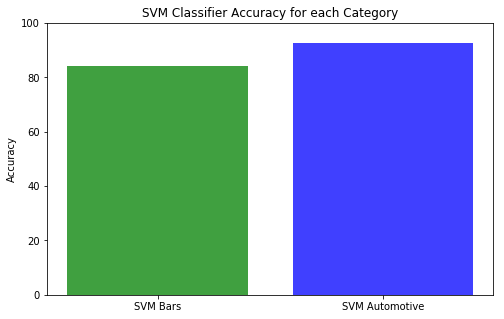

In [27]:
plt.figure(figsize=(8,5))
plt.bar(["SVM Bars","SVM Automotive"],[accuracy_bars_svm*100,accuracy_auto_svm*100],alpha=0.75,color=['green','blue'])
plt.ylabel("Accuracy")
plt.ylim(0,100)
plt.title("SVM Classifier Accuracy for each Category")
plt.show()

It is visible from above bar chart that the SVM predicted automotive data with much more accuracy than bars data

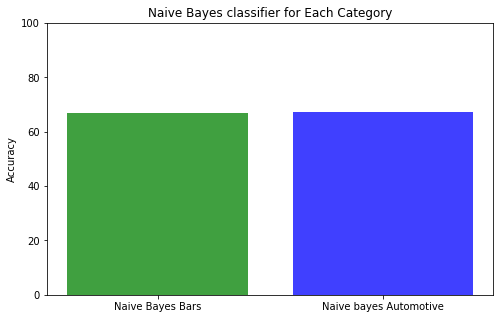

In [28]:
plt.figure(figsize=(8,5))
plt.bar(["Naive Bayes Bars","Naive bayes Automotive"],[accuracy_bars_nb*100,accuracy_auto_nb*100],alpha=0.75,color=['green','blue'])
plt.ylabel("Accuracy")
plt.ylim(0,100)
plt.title("Naive Bayes classifier for Each Category")
plt.show()

It can be seen that Naive bayes predicted both category data with almost same accuracy. Also, Naives bayes predicted the class with lowest accuracy among all the classifiers 

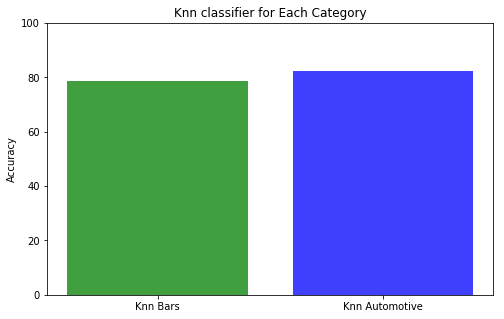

In [29]:
plt.figure(figsize=(8,5))
plt.bar(["Knn Bars","Knn Automotive"],[accuracy_bars_knn*100,accuracy_auto_knn*100],alpha=0.75,color=['green','blue'])
plt.ylabel("Accuracy")
plt.ylim(0,100)
plt.title("Knn classifier for Each Category")
plt.show()

Just like other classifers, Knn perfored well for automotive data then bars data

### Task 3 Conclusion

##### Bar Model on Automotive data Vs. Automotive Model on Bars Data

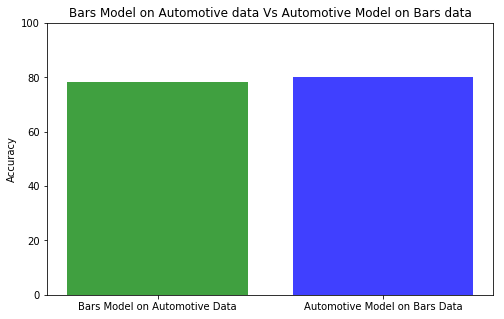

In [30]:
plt.figure(figsize=(8,5))
plt.bar(["Bars Model on Automotive Data","Automotive Model on Bars Data"],[accuracy_bars_auto*100,accuracy_auto_bars*100],alpha=0.75,color=['green','blue'])
plt.ylabel("Accuracy")
plt.ylim(0,100)
plt.title("Bars Model on Automotive data Vs Automotive Model on Bars data")
plt.show()

It can be seen that the accuracy of both the model dropped a bit when tested with data from other category. The accuracy drop in case of bars model (SVM Classifier) is less (from 84.28 to 78.47) than the accuracy drop in case of automotive model (SVM Classifier) (from 92.67 to 80.20). Despite being more drop in accuracy in case of automotive model, it out perform the bars model in both the cases ( when tested with same category data and when tested with other category data)